In [6]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

from epa import *
from sample_processing import *
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
%autoreload 2

# Generating Random Data

In [12]:
np.random.seed(0)

In [13]:
# Set 3 clusters with different regression params
mus = [5, 0 ,5, 0]
sds = [1, 1, 1, 1]
n_points_per_clust = 50

betas = [np.array([-3,-5]),
         np.array([20,-5]),
         np.array([1,5]),
         np.array([-20,5])]

sigmas = [0.5,1,2,1]

# Generate data
Xs = []
Ys = []

for k in range(len(mus)):
    
    X_k = np.random.normal(mus[k],sds[k],n_points_per_clust)
    y_k = betas[k][0] + betas[k][1]*X_k + np.random.normal(0,sigmas[k],n_points_per_clust)
    
    Xs.append(X_k)
    Ys.append(y_k)

Xs = np.concatenate(Xs)
Ys = np.concatenate(Ys)
inds = np.array(n_points_per_clust*[0] + n_points_per_clust*[1] +\
                n_points_per_clust*[2]+ n_points_per_clust*[3])

# Randomly permutate
random_perm = np.arange(len(Xs))
np.random.shuffle(random_perm)

In [14]:
col_map = ['r','b','g','k']

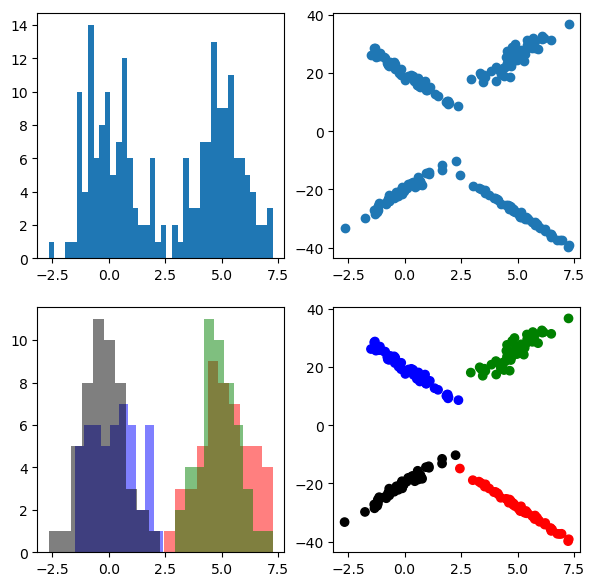

In [15]:
fig, ax = plt.subplots(2,2,figsize=(7,7))

ax[0,0].hist(Xs,bins=40)
ax[0,1].scatter(Xs,Ys)

for i in np.unique(inds):
    ax[1,0].hist(Xs[np.where(inds==i)],
                 color=col_map[i],alpha=0.5)

ax[1,1].scatter(Xs,Ys,c=[col_map[i] for i in inds])
plt.show()

# Run Gibbs Sampler

In [16]:
Xs = Xs[random_perm].reshape(-1,1)
Ys = Ys[random_perm]
Zs = Xs[random_perm]

Xs = np.hstack([np.ones(len(Xs)).reshape(-1,1),Xs])

In [17]:
import time

In [18]:
np.random.seed(1)

In [53]:
#%%prun -T report.txt

start_time = time.time()

# Dist mat
tau = 0.5
lambda_matrix = pairwise_distances(X=Zs.reshape(-1,1), metric=exp_sim_func, tau=tau)

# intialize 
partition_samp = np.array(n_points_per_clust*[1]+\
                          n_points_per_clust*[2]+\
                          n_points_per_clust*[3]+\
                          +n_points_per_clust*[3])
names_used = [1,2,3]
alpha_samp = 1

delta_samp = 0
sim_mat = lambda_matrix
order_samp = np.arange(len(Ys))
np.random.shuffle(order_samp)
phi_samp = np.array([[0.5,0.5],
                     [2,2],
                     [-1,-1]])

#### gibbs sampling hyper parameters
n_gibbs = 6000
n_burn_in = 1000
k = 150 # no. of numbers to permute order

# GRW sampler param
rw_sd = 0.2

# alpha prior
a_alpha = 1
b_alpha = 10
alpha_bounds = [0,1e99]

# delta prior
a_delta = 1
b_delta = 1
w = 0.5
delta_bounds = [0,1]

# phi / regression prior
phi_mean_prior = np.array([0,0])
phi_cov_prior = np.array([[1,0],[0,1]])
sigma_reg = 1

partition_save = []
alpha_save = []
delta_save = []
phi_save = []
log_prob_save = []

# Gibbs loop
for g in range(n_gibbs):
    if g%100 == 0:
        print("Gibbs: ", g)
        
    # Sample cluster for each i 
    for i in range(len(Ys)):

        partition_samp, phi_samp, names_used = sample_conditional_i_clust_alt(i,
                                         partition_samp,
                                         alpha_samp,
                                         delta_samp,
                                         sim_mat,
                                         order_samp,
                                         phi_samp, Ys, Xs, sigma_reg,
                                        names_used,
                                         phi_base_mean=phi_mean_prior,
                                            phi_base_cov=phi_cov_prior,
                                            reordering=False)
        
        #print(i)
    
    # Update phis
    phi_samp = sample_phi(phi_samp, Ys, Xs, partition_samp,
               phi_mean_prior,
               phi_cov_prior,
               sigma_reg)
    
    # Sample ordering 
    #order_samp = permute_k(order_samp, k)
    order_samp = metropolis_step_order(order_current=order_samp,
                                       alpha=alpha_samp,
                                       delta=delta_samp,
                                       partition=partition_samp,
                                       sim_mat=sim_mat,
                                       k=k)
    
    #### Sample parameters, alpha, sigma
    
    alpha_samp = metropolis_step_alpha(alpha_samp, rw_sd, a_alpha, b_alpha,
                         partition_samp,
                             delta_samp,
                             sim_mat,
                             order_samp,bounds=alpha_bounds)
    
    
    delta_samp = metropolis_step_delta(delta_samp, rw_sd, a_delta, b_delta, w,
                         partition_samp,
                             alpha_samp,
                             sim_mat,
                             order_samp,bounds=delta_bounds)
    
    
    # Calc log prob of result
    log_prob_samp = calc_log_joint(partition=partition_samp,
                                   phi=phi_samp,
                                   y=Ys,
                                   x=Xs,
                                   sim_mat=sim_mat,
                                   order=order_samp,
                                   alpha=alpha_samp,
                                   delta=delta_samp,
                                   sigma_reg = sigma_reg)
    
    # Save sampled values
    log_prob_save.append(log_prob_samp)
    partition_save.append(partition_samp)
    alpha_save.append(alpha_samp)
    delta_save.append(delta_samp)
    phi_save.append(phi_samp)
    
end_time = time.time()
print("Time taken to run ",n_gibbs, " | ", (end_time-start_time)/60)

Gibbs:  0
Gibbs:  100
Gibbs:  200
Gibbs:  300
Gibbs:  400
Gibbs:  500
Gibbs:  600
Gibbs:  700
Gibbs:  800
Gibbs:  900
Gibbs:  1000
Gibbs:  1100
Gibbs:  1200
Gibbs:  1300
Gibbs:  1400
Gibbs:  1500
Gibbs:  1600
Gibbs:  1700
Gibbs:  1800
Gibbs:  1900
Gibbs:  2000
Gibbs:  2100
Gibbs:  2200
Gibbs:  2300
Gibbs:  2400
Gibbs:  2500
Gibbs:  2600
Gibbs:  2700
Gibbs:  2800
Gibbs:  2900
Gibbs:  3000
Gibbs:  3100
Gibbs:  3200
Gibbs:  3300
Gibbs:  3400
Gibbs:  3500
Gibbs:  3600
Gibbs:  3700
Gibbs:  3800
Gibbs:  3900
Gibbs:  4000
Gibbs:  4100
Gibbs:  4200
Gibbs:  4300
Gibbs:  4400
Gibbs:  4500
Gibbs:  4600
Gibbs:  4700
Gibbs:  4800
Gibbs:  4900
Gibbs:  5000
Gibbs:  5100
Gibbs:  5200
Gibbs:  5300
Gibbs:  5400
Gibbs:  5500
Gibbs:  5600
Gibbs:  5700
Gibbs:  5800
Gibbs:  5900
Time taken to run  6000  |  26.298098182678224


- Time taken to run  6000  |  29.023514982064565 (pandas)
- Time taken to run  6000  |  29.245565966765085 (re-index numpy)
- Time taken to run  3000  |  13.071634848912558 (ori)
- Time taken to run  3000  |  15.427171734968821 (with re-index)

# Calculating Similarity Matrix from MCMC samples

In [20]:
normalized_sim_mat = calc_hit_matrix(partition_save,
                                     burn_samples=2000,
                                     normalize=True)

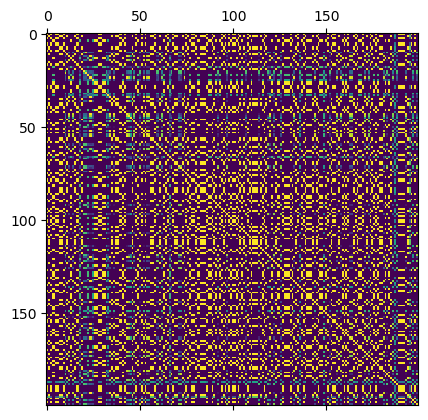

In [21]:
plt.matshow(normalized_sim_mat)
plt.show()

In [22]:
sample_n_clusters = [len(np.unique(p)) for p in partition_save]

In [54]:
np.mean(sample_n_clusters[1000:])

5.0706

In [61]:
agglo_cluster_solution = agglo_cluster(sim_matrix=normalized_sim_mat,
                                       n_clust=4,
                                       linkage_type='average')

In [62]:
pd.Series(agglo_cluster_solution).value_counts()

2    51
0    51
1    49
3    49
dtype: int64

In [37]:
col_map=['r', 'b', 'g','k','m','y','tab:orange']

In [38]:
inds = pd.Series(agglo_cluster_solution).value_counts().index

In [39]:
pd.Series(agglo_cluster_solution).value_counts().index

Int64Index([2, 0, 1, 3], dtype='int64')

In [40]:
inds

Int64Index([2, 0, 1, 3], dtype='int64')

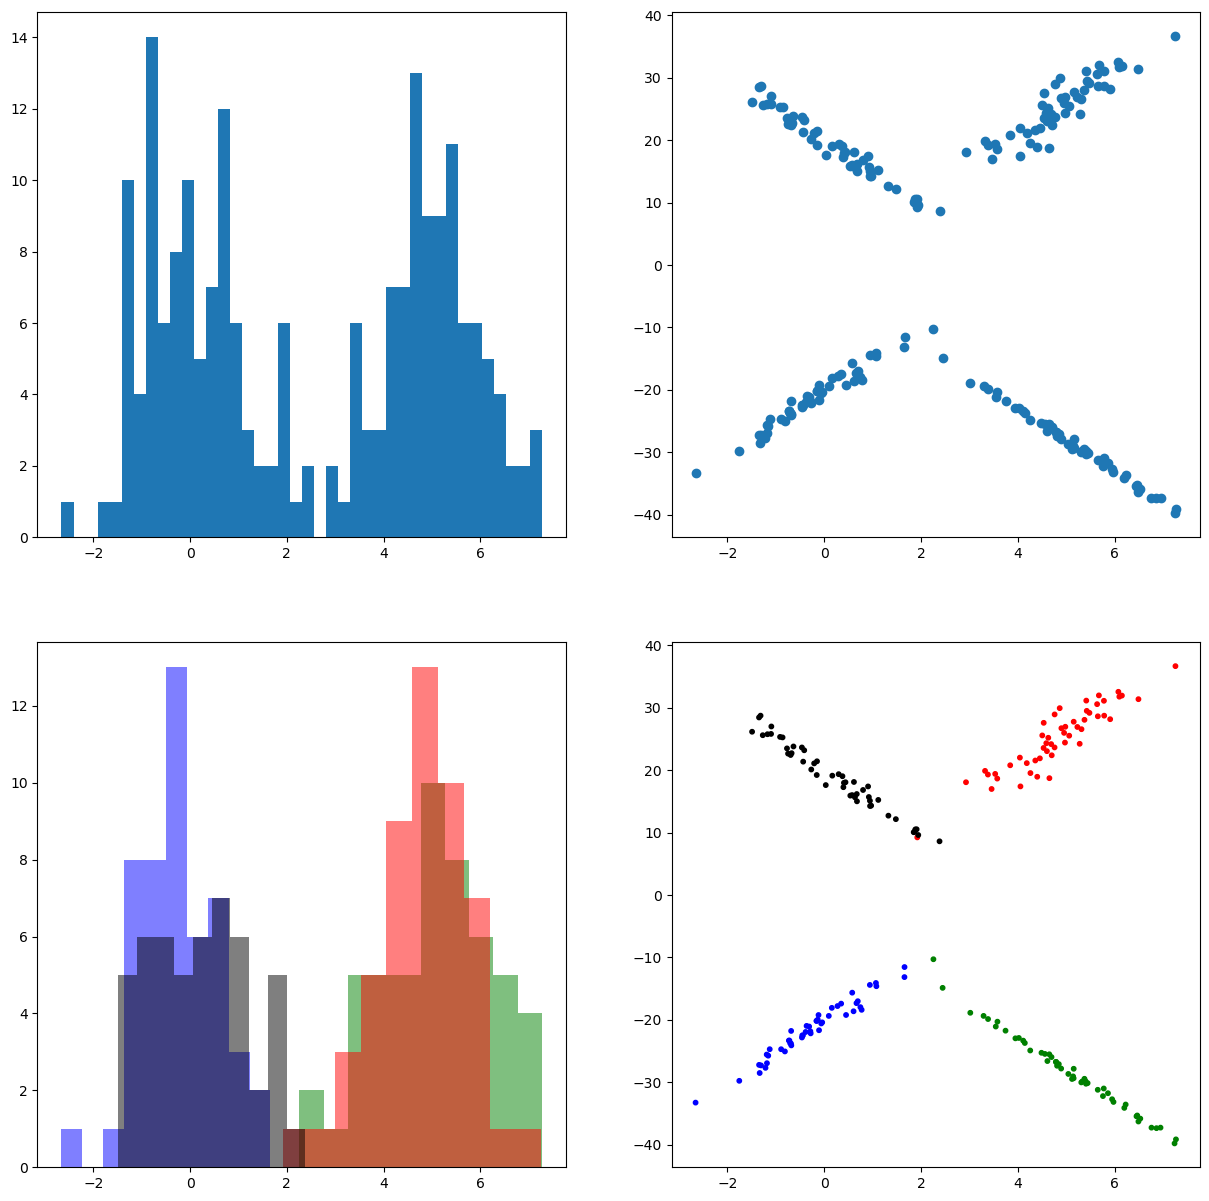

In [41]:
fig, ax = plt.subplots(2,2,figsize=(15,15))

ax[0,0].hist(Xs[:,1],bins=40)
ax[0,1].scatter(Xs[:,1],Ys)

for i in inds:
    ax[1,0].hist(Xs[:,1][np.where(agglo_cluster_solution==i)],
                 color=col_map[i],alpha=0.5)

ax[1,1].scatter(Xs[:,1],Ys,c=[col_map[i] for i in agglo_cluster_solution],s=10)
plt.show()

# MCMC Diagnostics

- How to diagnose convergence of clusterings?
- ARI between pairs

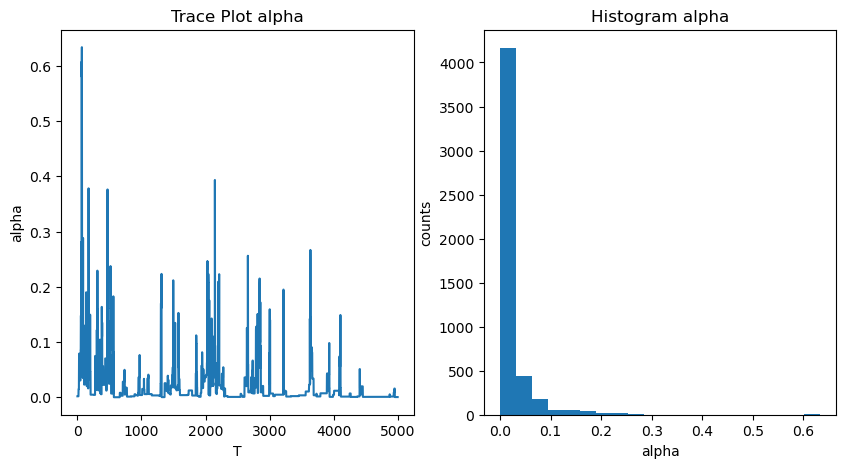

In [42]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(alpha_save[1000:])
ax[0].set_xlabel('T')
ax[0].set_ylabel('alpha')
ax[0].set_title('Trace Plot alpha')

ax[1].hist(alpha_save[1000:],bins=20)
ax[1].set_xlabel('alpha')
ax[1].set_ylabel('counts')
ax[1].set_title('Histogram alpha')
plt.show()


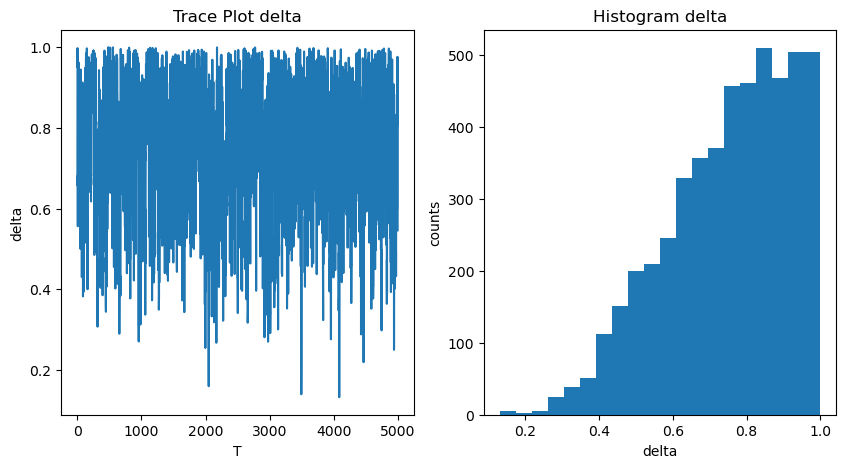

In [43]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(delta_save[1000:])
ax[0].set_xlabel('T')
ax[0].set_ylabel('delta')
ax[0].set_title('Trace Plot delta')

ax[1].hist(delta_save[1000:],bins=20)
ax[1].set_xlabel('delta')
ax[1].set_ylabel('counts')
ax[1].set_title('Histogram delta')
plt.show()

In [44]:
partition_save

[array([ 6,  6,  6,  8,  1,  2,  2,  6,  4,  2,  1,  4,  1,  1,  1,  6,  2,
         2,  1,  4,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  1,  1,  1,  1,
         1,  6,  1,  4,  7,  2,  2,  2,  2,  1,  1,  1,  4,  1,  2,  1,  1,
         2,  1,  2,  1,  1,  4,  6,  2,  1,  1,  6,  1,  1,  4,  2,  1,  1,
         2,  6,  4,  1,  1,  7,  1,  2,  4,  1,  2,  2,  4,  1,  1,  4,  4,
         7,  2,  1,  2,  2,  4,  1,  1,  1,  2,  6,  2,  1,  3,  2,  3,  3,
         1,  3,  4,  2,  4,  1,  3,  4,  1, 10,  7,  4,  1,  4,  8,  3,  4,
         1,  1,  1,  1,  4, 11,  1,  1,  3,  1,  1, 12,  3,  9,  1,  4,  3,
         1,  1,  3,  4,  2,  1,  1,  4,  1,  7,  3,  2,  1,  1,  1,  3,  1,
         7,  3,  3,  1,  7,  1,  1,  3,  2,  3,  1,  1,  4,  3,  7,  2,  1,
         3,  1,  4,  5,  3,  5,  9,  3,  2,  5,  5,  5,  1,  5, 13,  7,  5,
         3,  5,  3,  3,  3,  3,  5,  7,  3,  3,  5,  3,  5]),
 array([2, 8, 2, 4, 1, 2, 2, 3, 3, 2, 1, 3, 5, 1, 5, 3, 8, 2, 6, 3, 1, 6,
        6, 1, 1, 6, 6, 1, 2,

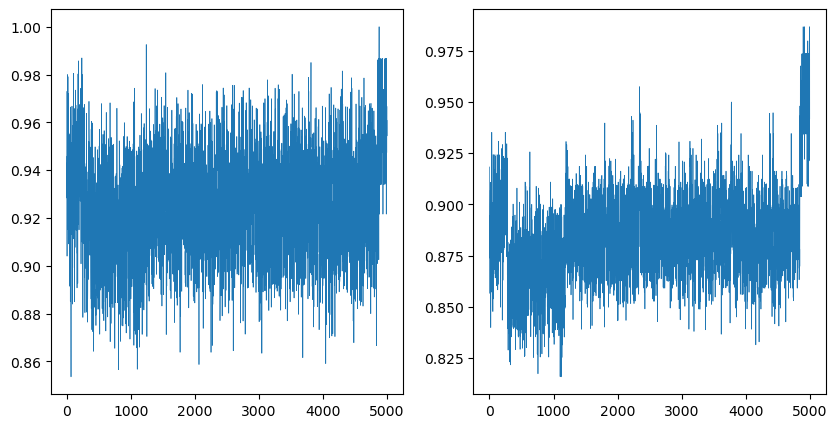

In [47]:
from sklearn.metrics import adjusted_rand_score
fig, ax = plt.subplots(1,2, figsize=(10,5))

ari_scores_within_samples = []
ari_scores_with_ext_clust = []
for t in range(n_burn_in, n_gibbs-1):
    
    ari_scores_within_samples.append(adjusted_rand_score(partition_save[t],
                                          partition_save[t+1]))
    
    ari_scores_with_ext_clust.append(adjusted_rand_score(partition_save[t],
                                      agglo_cluster_solution))
    
    

ax[0].plot(ari_scores_within_samples,lw=0.5)
ax[1].plot(ari_scores_with_ext_clust,lw=0.5)